<a href="https://colab.research.google.com/github/thangthao22/python-training/blob/main/B%C3%A0i_gi%E1%BA%A3ng_3___nguy%C3%AAn_l%C3%BD_x%C3%A2y_d%E1%BB%B1ng_FL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

hoàn thành bài tập phần bài giảng 3

Saving Assignment_MLBasicsData.csv to Assignment_MLBasicsData.csv


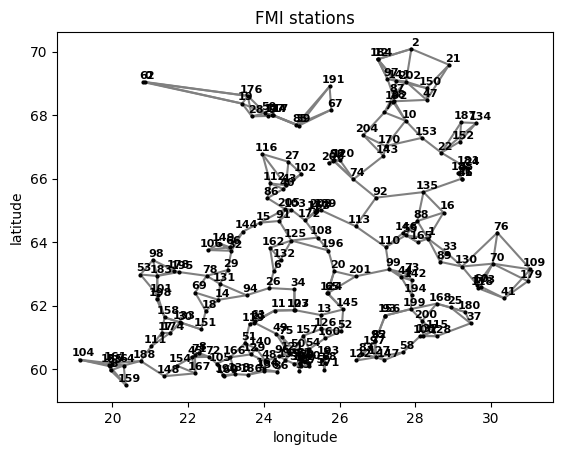

Training error: 32.96284095952609
Total variation: 204.21481183181655


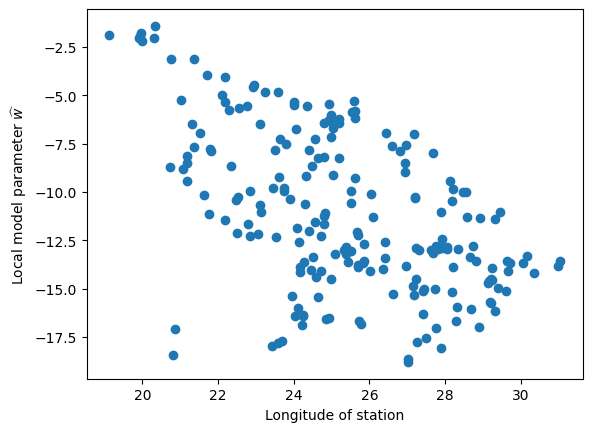

numneighbors = 1: Connected = False
numneighbors = 2: Connected = False
numneighbors = 3: Connected = False
numneighbors = 4: Connected = True
Alpha = 1: Train Error = 33.72827289106725, Total Variation = 293.66532337182883
Alpha = 10: Train Error = 36.962043351713035, Total Variation = 66.95593556679522
Alpha = 100: Train Error = 45.57491415104351, Total Variation = 5.513418883106931
Alpha = 1000: Train Error = 50.84980813988907, Total Variation = 0.0889046331357936


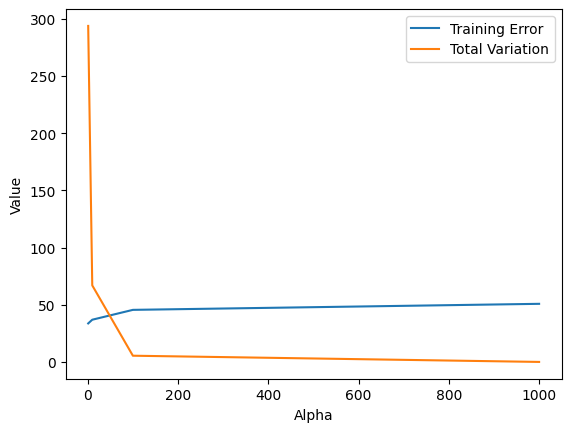

In [ ]:
# Import các thư viện cần thiết
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import networkx as nx
from sklearn.neighbors import kneighbors_graph
from google.colab import files  # Thêm thư viện để tải file lên Colab

# Hàm hỗ trợ để vẽ đồ thị FMI
def plotFMI(G_FMI):
    num_stations = len(G_FMI.nodes)
    coords = [G_FMI.nodes[i]['coord'] for i in range(num_stations)]
    df_coords = pd.DataFrame(coords, columns=['latitude', 'longitude'])
    coords = np.hstack((df_coords["latitude"].to_numpy().reshape(-1,1), df_coords["longitude"].to_numpy().reshape(-1,1)))
    fig, ax = plt.subplots()
    for node in G_FMI.nodes:
        ax.scatter(coords[node,1], coords[node,0], color='black', s=4, zorder=5)
        ax.text(coords[node,1]+0.1, coords[node,0]+0.2, str(node), fontsize=8, ha='center', va='center', color='black', fontweight='bold')
    for edge in G_FMI.edges:
        ax.plot([coords[edge[0],1], coords[edge[1],1]], [coords[edge[0],0], coords[edge[1],0]], linestyle='-', color='gray')
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    ax.set_title('FMI stations')
    plt.show()

# Hàm thêm cạnh vào đồ thị
def add_edges(graph, numneighbors=4):
    coords = [graph.nodes[i]['coord'] for i in range(len(graph.nodes))]
    df_coords = pd.DataFrame(coords, columns=['latitude', 'longitude'])
    coords = np.hstack((df_coords["latitude"].to_numpy().reshape(-1,1), df_coords["longitude"].to_numpy().reshape(-1,1)))
    A = kneighbors_graph(coords, numneighbors, mode='connectivity', include_self=False)
    nrnodes = len(graph.nodes)
    for iter_i in range(nrnodes):
        for iter_ii in range(nrnodes):
            if iter_i != iter_ii and A[iter_i, iter_ii] > 0:
                graph.add_edge(iter_i, iter_ii)
    return graph

# Hàm tính lỗi huấn luyện
def compute_train_err(graph, localparam):
    nrnodes = len(graph.nodes)
    tmp = 0
    for iter_i in range(nrnodes):
        predictions = np.ones((graph.nodes[iter_i]['samplesize'], 1)) * localparam[iter_i]
        local_loss = mean_squared_error(graph.nodes[iter_i]['y'], predictions)
        tmp += local_loss
    train_err = tmp / nrnodes
    return train_err

# Hàm tính tổng biến thiên
def compute_totalvariation(graph, localparam):
    total_var = 0
    for u, v in graph.edges():
        total_var += (localparam[u] - localparam[v])**2
    return total_var

# Hàm trích xuất đặc trưng và nhãn
def ExtractFeaureMatrixLabvelVector(data):
    nrfeatures = 7
    nrdatapoints = len(data)
    X = np.zeros((nrdatapoints, nrfeatures))
    y = np.zeros((nrdatapoints, 1))
    for ind in range(nrdatapoints):
        lat = float(data['Latitude'].iloc[ind]) / 100
        lon = float(data['Longitude'].iloc[ind]) / 100
        tmp = data['temp'].iloc[ind]
        date_object = datetime.strptime(data['Timestamp'].iloc[ind], '%Y-%m-%d %H:%M:%S')
        year = float(date_object.year) / 2025
        month = float(date_object.month) / 13
        day = float(date_object.day) / 32
        hour = float(date_object.hour) / 25
        minute = float(date_object.minute) / 61
        X[ind, :] = [lat, lon, year, month, day, hour, minute]
        y[ind, :] = tmp
    return X, y

# 1. Tải file dữ liệu từ máy tính lên Colab
uploaded = files.upload()  # Tải file từ máy tính
data = pd.read_csv('Assignment_MLBasicsData.csv')  # Đọc file vừa tải lên
num_stations = len(data.name.unique())
num_datapoints = len(data)

# 2. Xây dựng đồ thị thực nghiệm
G_FMI = nx.Graph()
G_FMI.add_nodes_from(range(0, num_stations))
yglobal = np.array([])
for i, station in enumerate(data.name.unique()):
    station_data = data[data.name == station]
    X, y = ExtractFeaureMatrixLabvelVector(station_data)
    localsamplesize = len(y)
    G_FMI.nodes[i]['samplesize'] = localsamplesize
    G_FMI.nodes[i]['X'] = X
    G_FMI.nodes[i]['name'] = station
    G_FMI.nodes[i]['coord'] = (station_data.Latitude.unique()[0], station_data.Longitude.unique()[0])
    G_FMI.nodes[i]['y'] = y
    yglobal = np.append(yglobal, y)

numneighbors = 3
G_FMI = add_edges(G_FMI, numneighbors=numneighbors)
plotFMI(G_FMI)

# 3. Mô hình
# 3.1 Task #1 - Tính lỗi huấn luyện và tổng biến thiên
gtvmin_alpha = 1
L_FMI = nx.laplacian_matrix(G_FMI).toarray()
n = num_stations
Q = np.eye(n) + gtvmin_alpha * L_FMI
q = np.array([-2 * np.mean(G_FMI.nodes[i]['y']) for i in range(n)])
hat_w = (-1/2) * np.linalg.inv(Q) @ q

print("Training error:", compute_train_err(G_FMI, hat_w))
print("Total variation:", compute_totalvariation(G_FMI, hat_w))

coords = nx.get_node_attributes(G_FMI, 'coord')
coords = np.array(list(coords.values()))
plt.scatter(coords[:, 1], hat_w)
plt.xlabel("Longitude of station")
plt.ylabel("Local model parameter $\widehat{w}$")
plt.show()

# 3.2 Task #2 - Kiểm tra tính liên thông
for numneighbors in [1, 2, 3, 4]:
    G_FMI = nx.Graph()
    G_FMI.add_nodes_from(range(0, num_stations))
    for i, station in enumerate(data.name.unique()):
        station_data = data[data.name == station]
        X, y = ExtractFeaureMatrixLabvelVector(station_data)
        G_FMI.nodes[i]['samplesize'] = len(y)
        G_FMI.nodes[i]['X'] = X
        G_FMI.nodes[i]['name'] = station
        G_FMI.nodes[i]['coord'] = (station_data.Latitude.unique()[0], station_data.Longitude.unique()[0])
        G_FMI.nodes[i]['y'] = y
    G_FMI = add_edges(G_FMI, numneighbors=numneighbors)
    is_connected = nx.is_connected(G_FMI)
    print(f"numneighbors = {numneighbors}: Connected = {is_connected}")

# 3.3 Task #3 - Ảnh hưởng của alpha
numneighbors = 5
G_FMI = nx.Graph()
G_FMI.add_nodes_from(range(0, num_stations))
for i, station in enumerate(data.name.unique()):
    station_data = data[data.name == station]
    X, y = ExtractFeaureMatrixLabvelVector(station_data)
    G_FMI.nodes[i]['samplesize'] = len(y)
    G_FMI.nodes[i]['X'] = X
    G_FMI.nodes[i]['name'] = station
    G_FMI.nodes[i]['coord'] = (station_data.Latitude.unique()[0], station_data.Longitude.unique()[0])
    G_FMI.nodes[i]['y'] = y
G_FMI = add_edges(G_FMI, numneighbors=numneighbors)
L_FMI = nx.laplacian_matrix(G_FMI).toarray()

alphas = [1, 10, 100, 1000]
train_errors = []
total_variations = []
q = np.array([-2 * np.mean(G_FMI.nodes[i]['y']) for i in range(n)])

for alpha in alphas:
    Q = np.eye(n) + alpha * L_FMI
    hat_w = (-1/2) * np.linalg.inv(Q) @ q
    train_err = compute_train_err(G_FMI, hat_w)
    total_var = compute_totalvariation(G_FMI, hat_w)
    train_errors.append(train_err)
    total_variations.append(total_var)
    print(f"Alpha = {alpha}: Train Error = {train_err}, Total Variation = {total_var}")

plt.plot(alphas, train_errors, label="Training Error")
plt.plot(alphas, total_variations, label="Total Variation")
plt.xlabel("Alpha")
plt.ylabel("Value")
plt.legend()
plt.show()

test code cho bài báo định tuyến tú đưa

STATS
[{'CPU': 50.137359518394035, 'RAM': 73.55486650048579, 'node': 1},
 {'CPU': 27.998868449319314, 'RAM': 63.210315457764736, 'node': 2},
 {'CPU': 86.10483488156885, 'RAM': 58.33865747653716, 'node': 3},
 {'CPU': 10.424818870187433, 'RAM': 48.50265951789293, 'node': 4},
 {'CPU': 78.64404534980376, 'RAM': 45.07977063933558, 'node': 5},
 {'CPU': 88.68178484914905, 'RAM': 47.36911295474655, 'node': 6},
 {'CPU': 35.94833498038649, 'RAM': 26.382517102177708, 'node': 1},
 {'CPU': 51.74114905959268, 'RAM': 67.95268210770072, 'node': 2},
 {'CPU': 58.96219886068749, 'RAM': 58.24230561268132, 'node': 3},
 {'CPU': 49.89101273790201, 'RAM': 46.19350825118853, 'node': 4},
 {'CPU': 39.27672743826921, 'RAM': 49.96481389666178, 'node': 5},
 {'CPU': 22.706063987667868, 'RAM': 79.90290310856312, 'node': 6},
 {'CPU': 76.15288207941957, 'RAM': 39.39222170932194, 'node': 1},
 {'CPU': 28.888868775275274, 'RAM': 25.183539168158408, 'node': 2},
 {'CPU': 11.17219416946333, 'RAM': 21.119853750920296, 'node':

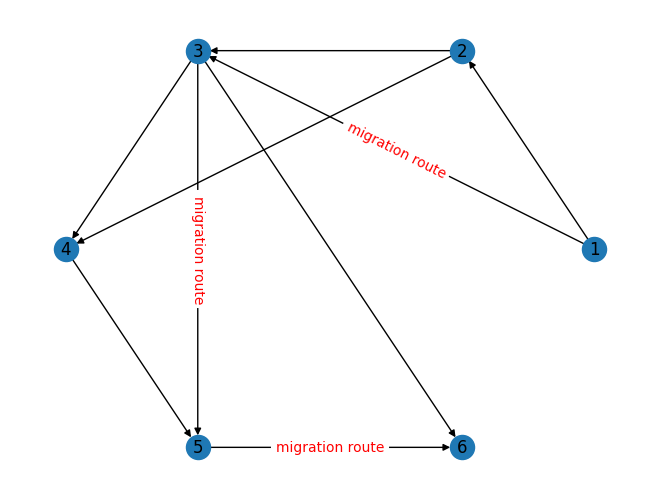

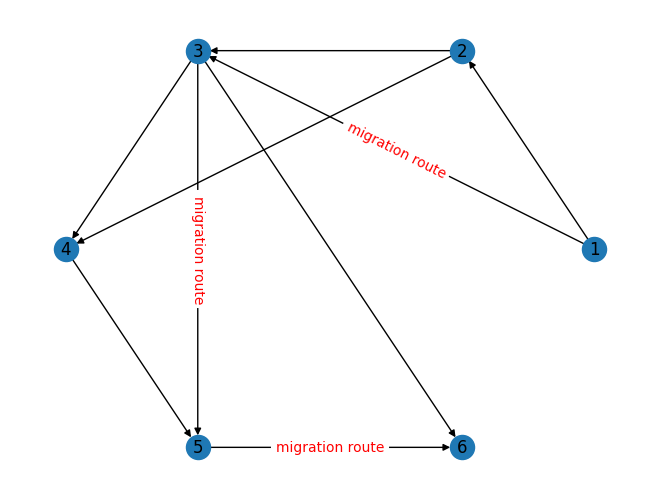

In [1]:
import os
import json
import time
import matplotlib.pyplot as plt
import networkx as nx
from pprint import pprint
import random

# Khởi tạo các thông số cơ bản
cores = 4 * (10**9)  # 4 tỷ nano cores
ram = 8 * (1024**3)  # 8GB RAM
nodes = [1, 2, 3, 4, 5, 6]
routes = [[1, 2, 3, 4, 5, 6], [1, 2, 3, 5, 6], [1, 2, 4, 5, 6], [1, 3, 5, 6], [1, 3, 4, 5, 6], [1, 2, 3, 6]]
stats, avgStat = [], {}
CPUw, RAMw, Dw, PLw = 0.275, 0.175, 0.275, 0.275  # Trọng số cho CPU, RAM, Delay, Packet Loss

# Hàm lấy thống kê cạnh (edge stats)
def getEdgeStats(routes):
    edges = []
    edgeStat = {}
    for route in routes:
        for i in range(len(route) - 1):
            f = True
            for j in edges:
                if (route[i], route[i + 1]) == j:
                    f = False
                    break
            if f:
                edges.append((route[i], route[i + 1]))
    for edge in edges:
        edgeStatsRow = {}
        edgeStatsRow['delay'] = random.randint(1, 5)  # Giả lập delay (ms)
        edgeStatsRow['packetLoss'] = random.randint(0, 10)  # Giả lập packet loss (%)
        edgeStat[edge] = edgeStatsRow
    return edgeStat

# Hàm giả lập lấy thống kê từ các node (thay vì dùng kubectl)
def getStatsFromNodes(nodes, cores, ram, stats, avgStat):
    for i in range(12):  # Giảm số lần lặp để chạy nhanh hơn trên Colab (60/5 = 12)
        for node in nodes:
            statRow = {}
            statRow['node'] = node
            # Giả lập dữ liệu CPU và RAM
            statRow['CPU'] = random.uniform(10, 90)  # % CPU usage
            statRow['RAM'] = random.uniform(20, 80)  # % RAM usage
            stats.append(statRow)
        time.sleep(0.1)  # Giảm thời gian sleep để chạy nhanh hơn

    # Tính trung bình thống kê
    for node in nodes:
        avgCPU, avgRAM, cnt = 0, 0, 0
        for value in stats:
            if value['node'] == node:
                avgCPU += value['CPU']
                avgRAM += value['RAM']
                cnt += 1
        avgRow = {}
        avgRow['CPU'] = avgCPU / cnt
        avgRow['RAM'] = avgRAM / cnt
        avgStat[f'{node}'] = avgRow

# Hàm chọn tuyến đường hiệu quả bằng AODV cổ điển
def getRouteAODV(routes):
    migrationRoute = []
    minL = max(len(route) for route in routes)
    for route in routes:
        if len(route) < minL:
            minL = len(route)
            migrationRoute = route
    return migrationRoute

# Hàm lấy thống kê tuyến đường
def getRouteStats(routes, edgeStat):
    edges, routeStats = {}, {}
    for route in routes:
        name = ' '.join([str(elem) for elem in route])
        edges[f'{name}'] = []
        for i in range(len(route) - 1):
            edge = (route[i], route[i + 1])
            edges[f'{name}'].append(edge)

    for key, value in edges.items():
        routeStats[f'{key}'] = []
        for edge in value:
            edgeStatsRow = {}
            edgeStatsRow['delay'] = edgeStat[edge]['delay']
            edgeStatsRow['packetLoss'] = edgeStat[edge]['packetLoss']
            routeStats[f'{key}'].append(edgeStatsRow)

    pprint(edges)
    pprint(routeStats)
    return routeStats

# Hàm chọn tuyến đường hiệu quả bằng EAODV cải tiến
def getRouteEAODV(routes, nodes, avgStat, routeStats):
    migrationRoute = []
    totalCosts = []
    for route in routes:
        totalCostsRow = {'route': [], 'cost': 0}
        nodesCost, edgesCost = 0, 0
        # Tính chi phí dựa trên CPU và RAM của các node
        for node in route:
            nodesCost += avgStat[f'{node}']['CPU'] * CPUw + avgStat[f'{node}']['RAM'] * RAMw
        # Tính chi phí dựa trên delay và packet loss của các cạnh
        for key, edgeStats in routeStats.items():
            if key == ' '.join([str(elem) for elem in route]):
                for edge in edgeStats:
                    edgesCost += edge['delay'] * Dw + edge['packetLoss'] * PLw
        routeCost = nodesCost + edgesCost
        totalCostsRow['route'] = route
        totalCostsRow['cost'] = routeCost
        totalCosts.append(totalCostsRow)
    pprint(totalCosts)
    # Chọn tuyến đường có chi phí thấp nhất
    minL = max(r['cost'] for r in totalCosts)
    for c in totalCosts:
        if c['cost'] <= minL:
            minL = c['cost']
            migrationRoute = c['route']
    return migrationRoute

# Hàm vẽ đồ thị
def getGraph(nodes, routes, migrationRoute):
    G = nx.DiGraph()
    edges = []
    for route in routes:
        for i in range(len(route) - 1):
            edge = (route[i], route[i + 1])
            edges.append(edge)

    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True)

    edgeLabels = {}
    for e in range(len(migrationRoute) - 1):
        edge = (migrationRoute[e], migrationRoute[e + 1])
        edgeLabels[edge] = 'migration route'

    nx.draw_networkx_edge_labels(
        G,
        pos,
        edge_labels=edgeLabels,
        font_color='red'
    )
    plt.show()

# Hàm chính
def main(nodes, cores, ram, stats, avgStat, routes):
    getStatsFromNodes(nodes, cores, ram, stats, avgStat)
    print("STATS")
    pprint(stats)

    print("node_STATS")
    pprint(avgStat)

    edgeStat = getEdgeStats(routes)
    print("edge_STATS")
    pprint(edgeStat)

    routeStats = getRouteStats(routes, edgeStat)

    migrationRouteAODV = getRouteAODV(routes)
    migrationRouteEAODV = getRouteEAODV(routes, nodes, avgStat, routeStats)

    print('recommended route by AODV: ', migrationRouteAODV)
    print('recommended route by EAODV: ', migrationRouteEAODV)

    getGraph(nodes, routes, migrationRouteAODV)
    getGraph(nodes, routes, migrationRouteEAODV)

# Chạy chương trình
main(nodes, cores, ram, stats, avgStat, routes)